# Heart Disease UCI

## features
1. age
2. sex
3. chest pain type (4 values): 
   - Value 0: asymptomatic
   - Value 1: atypical angina
   - Value 2: pain without relation to angina
   - Value 3: typical angina
4. resting blood pressure: Resting blood pressure in millimeters of mercury (mm Hg) 
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2):
    - Value 0: probable left ventricular hypertrophy
    - Value 1: normal
    - Value 2: abnormalities in the T wave or ST segment
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
    - Value 0: descending
    - Value 1: flat
    - Value 2: ascending
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, XGBoost
from sklearn.neural_network import MLPClassifier

ImportError: cannot import name 'XGBoost' from 'sklearn.ensemble' (/Users/Sherryliu/.local/share/virtualenvs/project-4Sw8Ehom/lib/python3.9/site-packages/sklearn/ensemble/__init__.py)

# Loading data

In [2]:
raw_data = pd.read_csv('processed.cleveland.data.csv', header=None)
raw_data.columns = ['Age', 'Sex', 'Chest_Pain', 'Resting_Blood_Pressure', 'Colestrol',
       'Fasting_Blood_Sugar', 'Rest_ECG', 'MAX_Heart_Rate',
       'Exercised_Induced_Angina', 'ST_Depression', 'Slope', 'Major_Vessels',
       'Thalessemia', 'Target']
print(raw_data.dtypes)
# check invalid values
invalid_val = '?'
invalid_rows = np.where(raw_data==invalid_val)[0]
print(np.unique(raw_data.Major_Vessels))
print(np.unique(raw_data.Thalessemia))
print('In this dataset, there are ' + str(len(invalid_rows)) + ' rows of data contains invalid value')
print('Size of dataset is ' + str(len(raw_data)))
print('Total ' + str(len(raw_data.columns)) + ' features')

Age                         float64
Sex                         float64
Chest_Pain                  float64
Resting_Blood_Pressure      float64
Colestrol                   float64
Fasting_Blood_Sugar         float64
Rest_ECG                    float64
MAX_Heart_Rate              float64
Exercised_Induced_Angina    float64
ST_Depression               float64
Slope                       float64
Major_Vessels                object
Thalessemia                  object
Target                        int64
dtype: object
['0.0' '1.0' '2.0' '3.0' '?']
['3.0' '6.0' '7.0' '?']
In this dataset, there are 6 rows of data contains invalid value
Size of dataset is 303
Total 14 features


In [3]:
# Remove rows containing invalid values
data = raw_data.drop(invalid_rows, axis = 0)
# convert data type of cols Major_Vessels and Thalessemia from object to int
data.Major_Vessels = data.Major_Vessels.values.astype(np.float64).astype(np.int64)
data.Thalessemia = data.Thalessemia.values.astype(np.float64).astype(np.int64)
data.Chest_Pain = data.Chest_Pain.values.astype(np.int64)
data.Rest_ECG = data.Rest_ECG.values.astype(np.int64)
data.Slope = data.Slope.values.astype(np.int64)

# Data exploration

In [4]:
data.describe()

,Age,Sex,Chest_Pain,Resting_Blood_Pressure,Colestrol,Fasting_Blood_Sugar,Rest_ECG,MAX_Heart_Rate,Exercised_Induced_Angina,ST_Depression,Slope,Major_Vessels,Thalessemia,Target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
# Split features into continous group and discrete group
cont_features = []
disc_features = []
binary_features = []
for i, col in enumerate(data.columns):
    if len(np.unique(data[col])) < 3:
        binary_features.append(col)
    if len(np.unique(data[col])) < 10:
        disc_features.append(col)
    else:
        cont_features.append(col)
        

print('Continous features:', cont_features)
print('Discrete features: ', disc_features)
print('Binary features: ', binary_features)

Continous features: ['Age', 'Resting_Blood_Pressure', 'Colestrol', 'MAX_Heart_Rate', 'ST_Depression']
Discrete features:  ['Sex', 'Chest_Pain', 'Fasting_Blood_Sugar', 'Rest_ECG', 'Exercised_Induced_Angina', 'Slope', 'Major_Vessels', 'Thalessemia', 'Target']
Binary features:  ['Sex', 'Fasting_Blood_Sugar', 'Exercised_Induced_Angina']


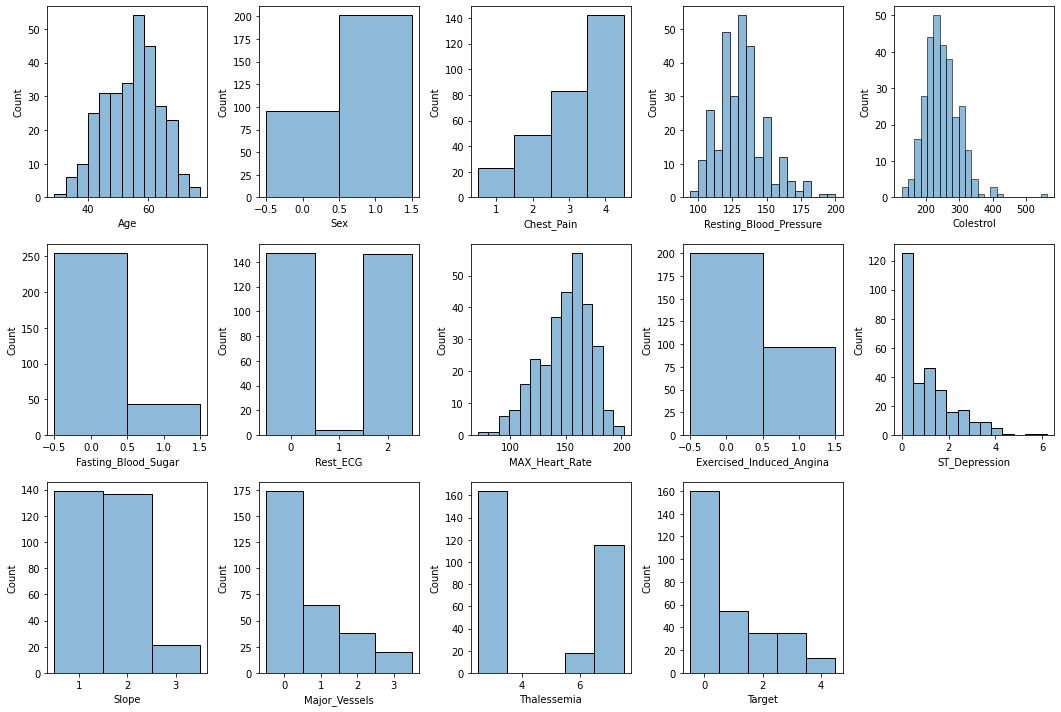

In [6]:
# Histogram of each features
fig, axes = plt.subplots(3,5, figsize=(15,10))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    discrete = False
    if col in disc_features:
        discrete = True
    sns.histplot(data[col], ax=axes[i], discrete=discrete, alpha=0.5)
plt.tight_layout()
fig.delaxes(axes[-1])

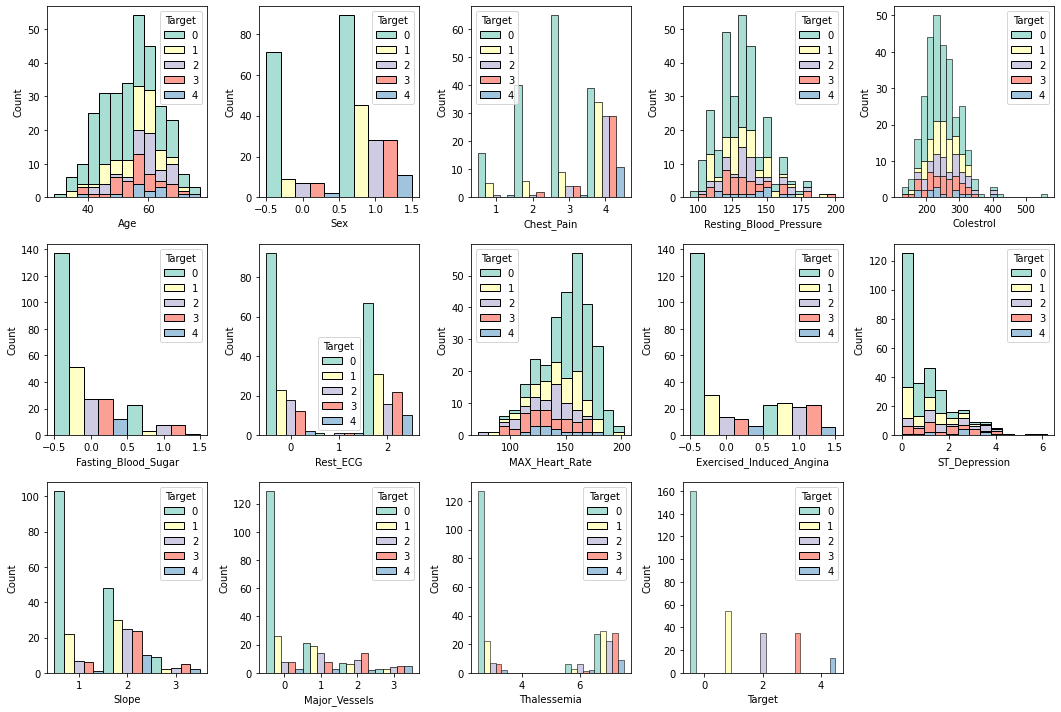

In [7]:
# Histogram of each features in different classes
fig, axes = plt.subplots(3,5, figsize=(15,10))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    if col in disc_features:
        sns.histplot(data=data, hue='Target', x=col, ax=axes[i], discrete=True, multiple='dodge',palette="Set3")
    elif col in cont_features:
        sns.histplot(data=data, hue='Target', x=col, ax=axes[i], discrete=False, multiple='stack',palette="Set3")
plt.tight_layout()
fig.delaxes(axes[-1])

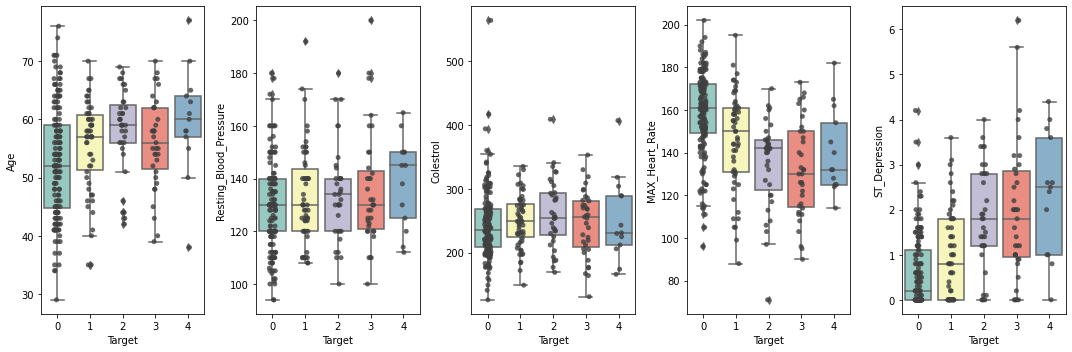

In [8]:
# box plots of different continous features
fig, axes = plt.subplots(1, 5, figsize=(15,5))
#axes = axes.flatten()

for i, col in enumerate(cont_features):
    sns.boxplot(data=data, y=col, x='Target', ax=axes[i], palette="Set3")
    sns.stripplot(x="Target", y=col, data=data, color="0.25", alpha=0.8, ax=axes[i])
plt.tight_layout()

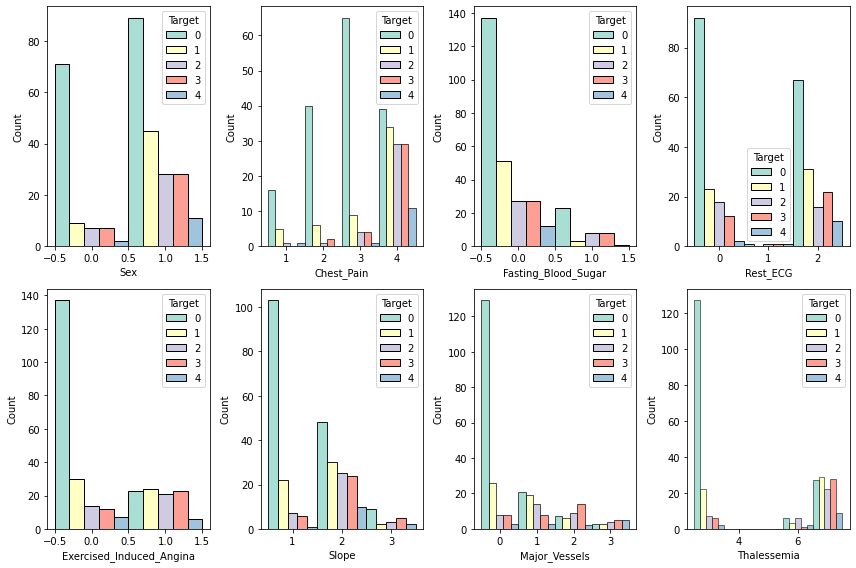

In [9]:
# Histogram of each features in different classes
fig, axes = plt.subplots(2,4, figsize=(12,8))
axes = axes.flatten()
for i, col in enumerate(disc_features[:-1]):
    sns.histplot(data=data, hue='Target', x=col, ax=axes[i], discrete=True, multiple='dodge',palette="Set3")
plt.tight_layout()

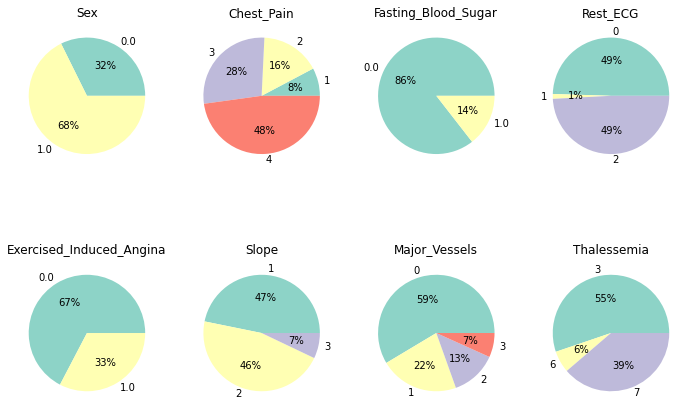

In [10]:
colors = sns.color_palette('Set3')
fig, axes = plt.subplots(2, 4, figsize=(12,8))
axes = axes.flatten()
for i, d_f in enumerate(disc_features[:-1]):
    v, c =  np.unique(data[d_f].values, return_counts=True)
    labels = [str(value) for value in v]
    axes[i].pie(c, labels=labels, colors = colors, autopct = '%0.0f%%')
    axes[i].set_title(d_f)
#plt.tight_layout()

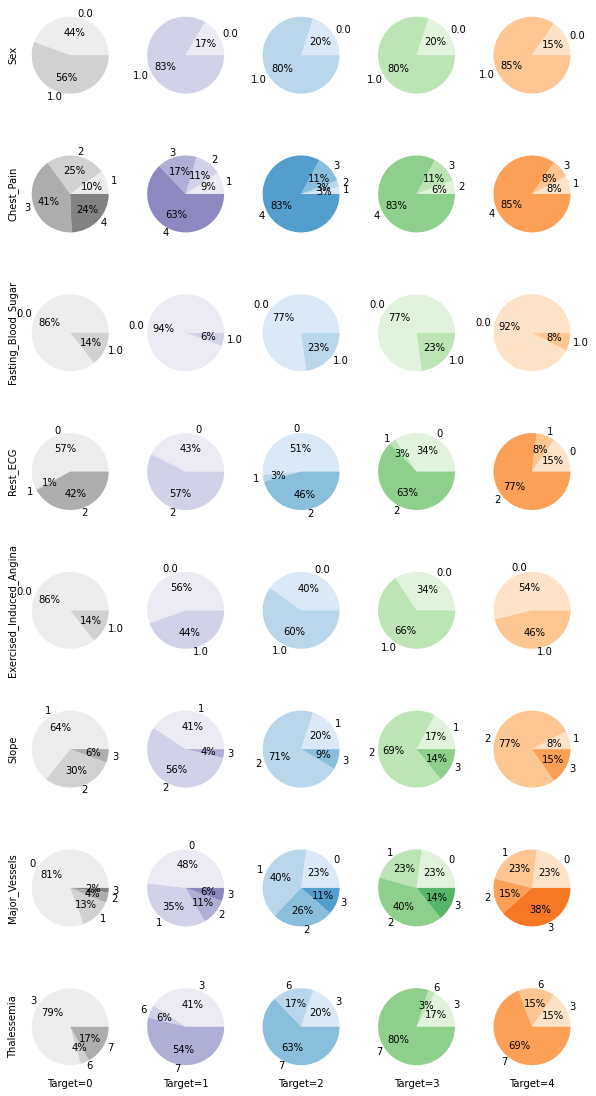

In [11]:
# plot pie for each classes each features
color_maps =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

fig, axes = plt.subplots(8, 5, figsize=(10,20), sharex=True, sharey=True)
for i, d_f in enumerate(disc_features[:-1]):
    for t in np.unique(data.Target.values):
        colors = sns.color_palette(color_maps[t])
        v, c =  np.unique(data[d_f][data.Target==t].values, return_counts=True)
        labels = [str(value) for value in v]
        axes[i][t].pie(c, labels=labels, colors = colors, autopct = '%0.0f%%')
        axes[-1][t].set_xlabel('Target='+str(t))
    axes[i][0].set_ylabel(d_f)


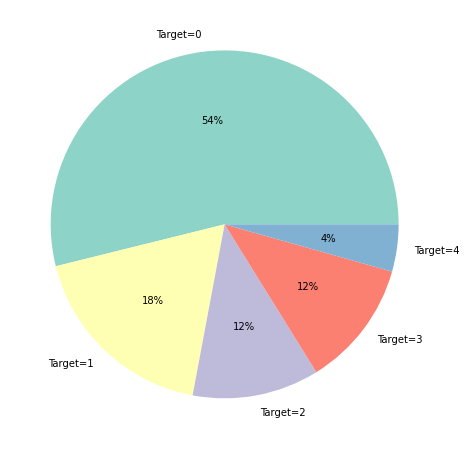

In [12]:
y_u, y_c =  np.unique(data.Target.values, return_counts=True)
labels = ['Target='+str(y) for y in y_u]
fig = plt.figure(figsize=(8, 8))
colors = sns.color_palette('Set3')
plt.pie(y_c, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

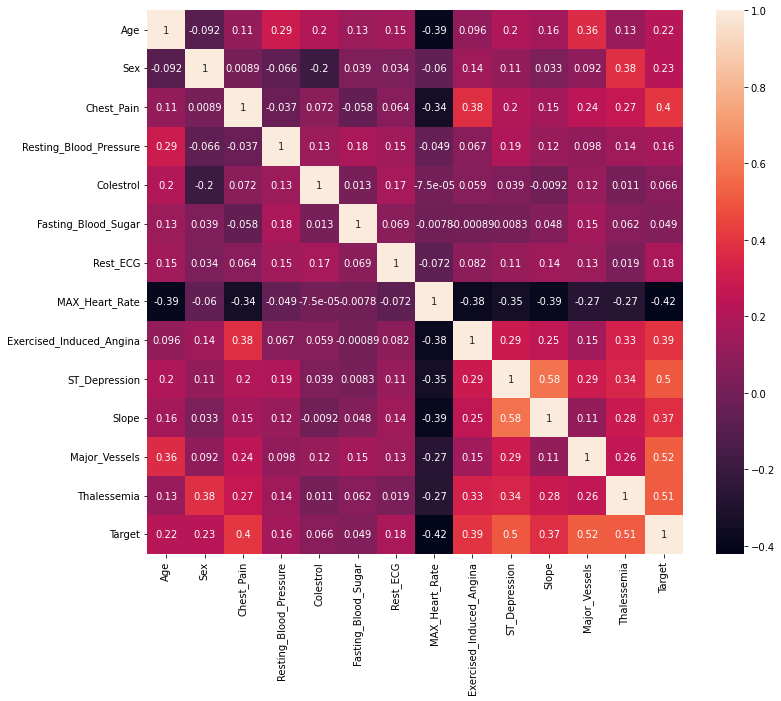

In [13]:
# correlation matrix
fig = plt.figure(figsize=(12,10))
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Data preprocessing

## Category features: One hot encoding
For category features, values do not indicate order but type only.

In [14]:
raw_data = data.copy()

In [15]:
# one hot encoding features
cat_features = ['Chest_Pain', 'Rest_ECG', 'Thalessemia', 'Slope', 'Major_Vessels']
for c_f in cat_features:
    one_hot = pd.get_dummies(data[c_f], prefix=c_f)
    data = pd.concat([data, one_hot], axis=1, join='inner')
    data = data.drop(c_f, axis=1)
print("After one-hot encoding, there are {} features in total.".format(len(data.columns)))

After one-hot encoding, there are 26 features in total.


## Standardization 
From box plots we can observe that continuous features contain outliers, therefore, we select a standardization method that is more robust to outliers. This method standardize each column based on values locating within a specific quantile range.

In [16]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
transform = RobustScaler().fit(data[cont_features])
for i, c_f in enumerate(cont_features[1:], 1):
    data[c_f] = transform.transform(data[cont_features])[:, i]

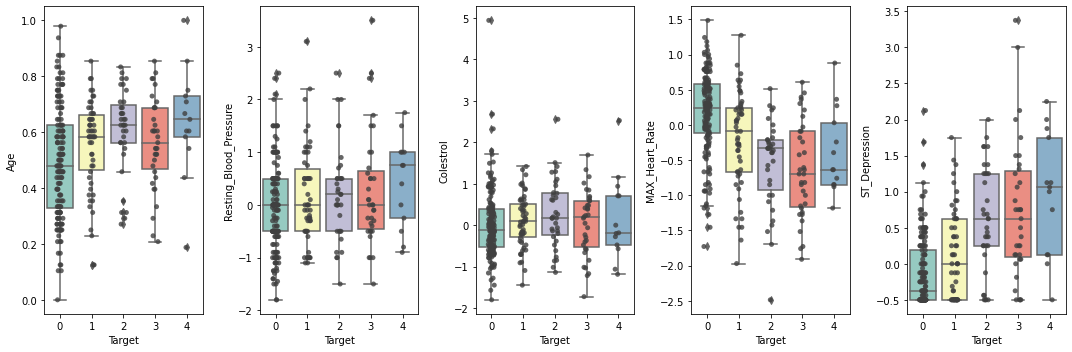

In [17]:
# Min-Max standardize Age
data.Age = MinMaxScaler().fit_transform(data.Age.values.reshape(-1, 1))

# box plots of different continous features after standardization
fig, axes = plt.subplots(1, 5, figsize=(15,5))
#axes = axes.flatten()

for i, col in enumerate(cont_features):
    sns.boxplot(data=data, y=col, x='Target', ax=axes[i], palette="Set3")
    sns.stripplot(x="Target", y=col, data=data, color="0.25", alpha=0.8, ax=axes[i])
plt.tight_layout()

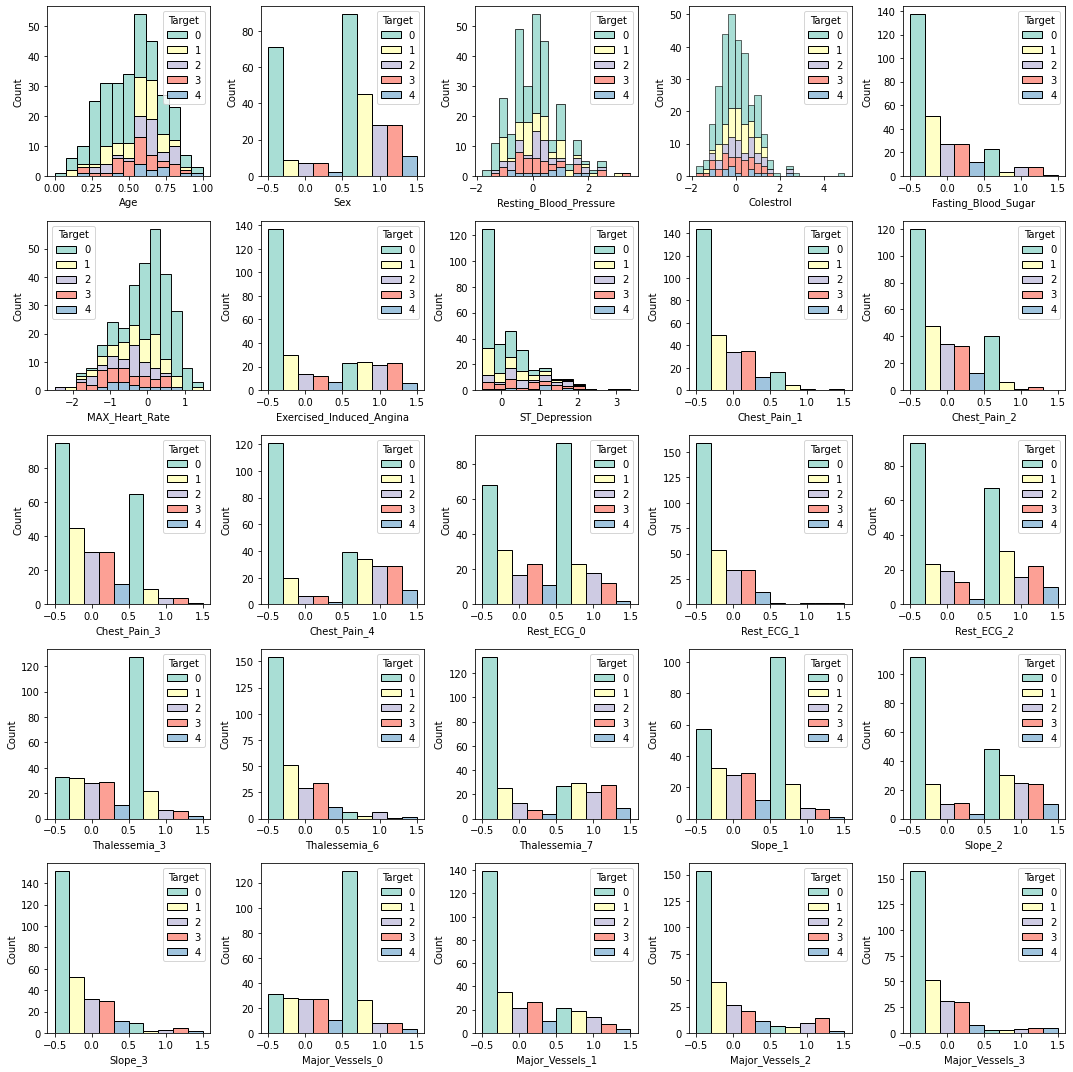

In [18]:
# Histogram of each features in different classes
fig, axes = plt.subplots(5,5, figsize=(15,15))
axes = axes.flatten()
for i, col in enumerate(data.drop('Target', axis=1).columns):
    if any([d_f in col for d_f in disc_features]):
        sns.histplot(data=data, hue='Target', x=col, ax=axes[i], discrete=True, multiple='dodge',palette="Set3")
    elif col in cont_features:
        sns.histplot(data=data, hue='Target', x=col, ax=axes[i], discrete=False, multiple='stack',palette="Set3")
plt.tight_layout()


## remove 'Sex' columns to avoid fairness problem

In [19]:
data = data.drop('Sex', axis=1)

## Remove outliers for continuous features

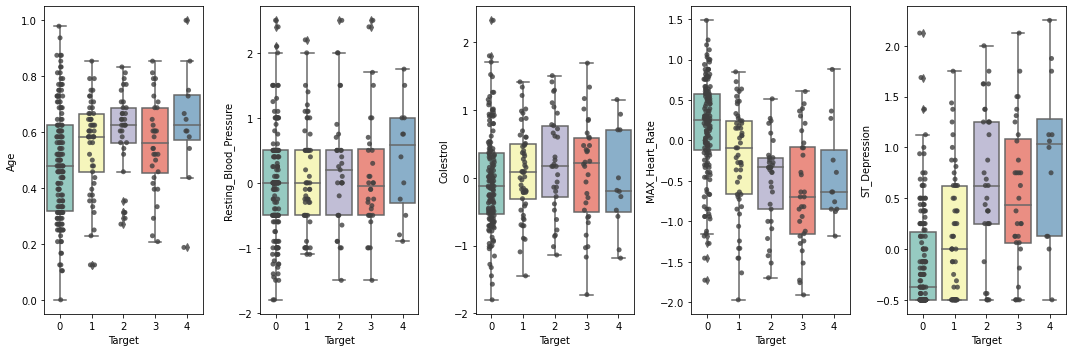

In [20]:
from scipy import stats
data_rm_outliers = data[(np.abs(stats.zscore(data[cont_features])) < 3).all(axis=1)]
fig, axes = plt.subplots(1, 5, figsize=(15,5))
#axes = axes.flatten()
for i, col in enumerate(cont_features):
    sns.boxplot(data=data_rm_outliers, y=col, x='Target', ax=axes[i], palette="Set3")
    sns.stripplot(x="Target", y=col, data=data_rm_outliers, color="0.25", alpha=0.8, ax=axes[i])
plt.tight_layout()

## Add columns mark has or no heart disease for binary classification task

In [21]:
# add columns mark has or no heart disease for binary classification task
data['target_bin'] = (data.Target > 0).astype(np.int64)

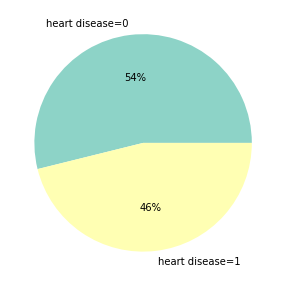

In [22]:
y_u, y_c =  np.unique(data.target_bin.values, return_counts=True)
labels = ['heart disease='+str(y) for y in y_u]
fig = plt.figure(figsize=(5, 5))
colors = sns.color_palette('Set3')
plt.pie(y_c, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

In [23]:
data.to_csv('prep_data.csv')

## Split into train test set

In [24]:
# Split into training set and testing set
def split_data(data, target, test_size=0.2, random_seed=42, stratify=True):
    X = data.drop(['target_bin', 'Target'], axis=1)
    y = data[target]
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=y.values,
                                                            random_state=random_seed,
                                                            shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=None,
                                                            random_state=random_seed,
                                                            shuffle=True)
        
    return X_train, X_test, y_train, y_test

In [25]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = split_data(data, target='target_bin')
X_train, X_test, y_train, y_test = split_data(data, target='Target')

# Metric for measuring performance: Confusion matrix

In [26]:
def confusion_matrix_display(ytrue, ypred, ax=None, cmap='Greens', classifier=''):
    cf_matrix = confusion_matrix(ytrue, ypred)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1)[:, np.newaxis], annot=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classifier)

# Binary Classification

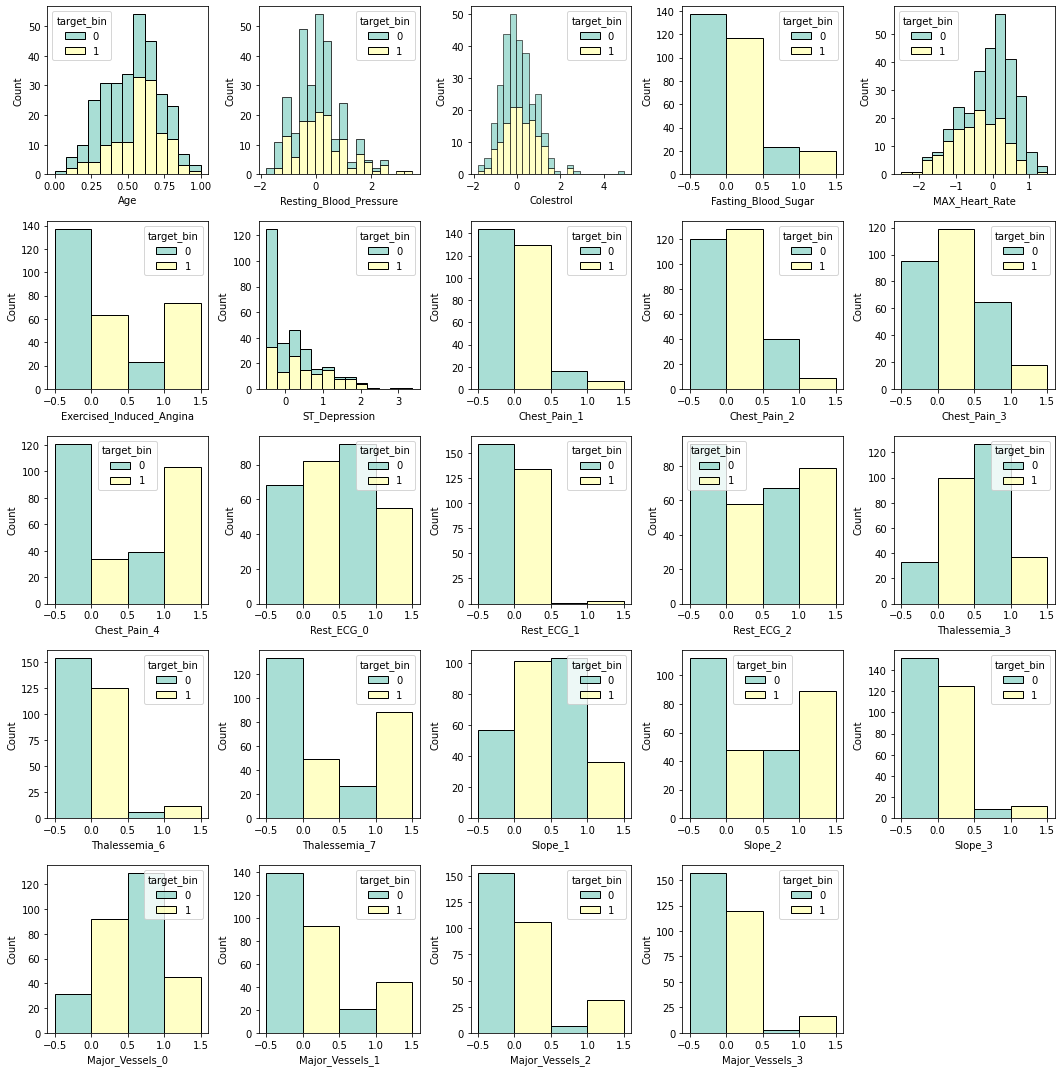

In [32]:
# check distribution of features for binary classification
fig, axes = plt.subplots(5,5, figsize=(15,15))
axes = axes.flatten()
for i, col in enumerate(X_train_bin.columns):
    if any([d_f in col for d_f in disc_features]):
        sns.histplot(data=data, hue='target_bin', x=col, ax=axes[i], discrete=True, multiple='dodge',palette="Set3")
    elif col in cont_features:
        sns.histplot(data=data, hue='target_bin', x=col, ax=axes[i], discrete=False, multiple='stack',palette="Set3")
plt.tight_layout()
plt.delaxes(axes[-1])

0.8333333333333334


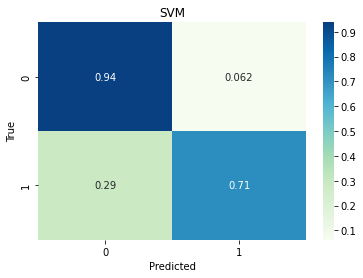

In [33]:
svc = SVC(C=2, kernel='linear', probability=True)
svc.fit(X_train_bin, y_train_bin)
svm_pred = svc.predict(X_test_bin)
confusion_matrix_display(y_test_bin, svm_pred, cmap='GnBu',classifier='SVM')
print(np.mean(svm_pred == y_test_bin))

0.8333333333333334


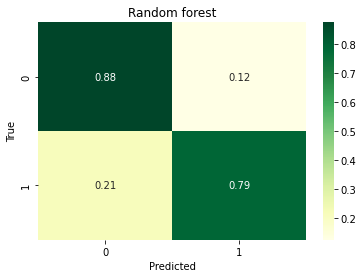

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train_bin, y_train_bin)
rf_predictions = rf_classifier.predict(X_test_bin)
confusion_matrix_display(y_test_bin, rf_predictions, cmap='YlGn', classifier='Random forest')
print(np.mean(svm_pred == y_test_bin))

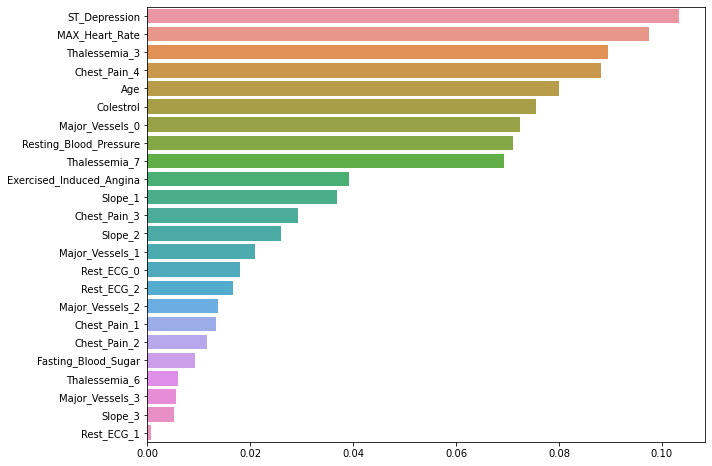

In [35]:
# importances of features
fig = plt.figure(figsize=(10, 8))
features_name = X_train.columns[np.argsort(rf_classifier.feature_importances_)[::-1]]
ax = sns.barplot(y=features_name, x=np.sort(rf_classifier.feature_importances_)[::-1], orient='h')
